# Solving neural networks with PINNs

This is a demonstration of using PINNS to solve two initial-boundary values for the one-dimensional wave equation, $u_{tt} = c^2 u_{xx}$, as well as the nonlinear one-dimensional wave equation $u_{tt} = c^2 u_{xx} + \epsilon u^2$. We use the free and open-source [PINA library](https://mathlab.github.io/PINA/) for this purpose.

In [191]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import warnings
import pickle
from tqdm import tqdm, trange

from pina import Condition, LabelTensor, Trainer
from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operator import laplacian, grad
from pina.domain import CartesianDomain
from pina.model import FeedForward
from pina.model.block import PeriodicBoundaryEmbedding
from pina.loss import LpLoss
from pina.solver import PINN
from pina.equation import Equation, FixedValue
from pina.callback import MetricTracker
from pina.optim import TorchOptimizer

In [2]:
%matplotlib inline
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.autolayout'] = True
plt.rcParams["axes.grid"] = True

In [3]:
infty = 20 # represented by a big number (but here I've kept it small for performance)
t_end = 10

In [5]:
constants = {
    "c": 1.0,
    "A": 3.0,
    "beta": 3.0,
    "t_end": 10.0,
    "epsilon": 1E-3,
    "period": 1.5
}

In [157]:
# utility function for plotting & visualization

@torch.no_grad()
def plot_solution(solver, time, savename=None, A=constants["A"], analytical_exists=True, ylim=None):
    # get spatial points
    problem = solver.problem
    spatial_samples = problem.spatial_domain.sample(3000, "grid")
    # get temporal value
    time = LabelTensor(torch.tensor([[time]]), "t")
    # cross data
    points = spatial_samples.append(time, mode="cross")
    # compute pinn solution, true solution and absolute difference
    # plot the solution
    title = f"Neural network solution at time $t={time.item():.2f}$"
    predicted_solution = solver(points)
    plt.plot(points.extract("x"), predicted_solution, label="Predicted solution")
    if analytical_exists:
        true_solution = problem.solution(points)
        mae = torch.max(torch.abs(predicted_solution - true_solution)).item()
        title += f"\nMax absolute error: {float(mae):.3f}"
        plt.title(title)
        plt.plot(points.extract("x"), true_solution, linestyle="dashed", label="True solution")
    else:
        plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel(r"$u\,(x, t)$")
    if not ylim:
        plt.ylim(0, A + 0.5) # default vertical bounds
    else:
        plt.ylim(*ylim)
    plt.legend()
    if not savename:
        plt.show()
    else:
        plt.savefig(savename)
        plt.cla()

## Wave equation with Gaussian bump

In this first part, we consider the standard wave equation $u_{tt} = c^2 u_{xx}$ with the following initial and boundary conditions:

$$
\begin{gather*}
u(x, 0) = A e^{-\beta x^2} \\
\dfrac{\partial u}{\partial t}(x, 0) = 0 \\
u(-\infty, t) = u(\infty, t) = 0 \\
x \in (-\infty, \infty)
\end{gather*}
$$

The analytical solution to this BVP is given by:

$$
u(x, t) =\frac{A}{2}\left(e^{-\beta\left(x+ct\right)^{2}}+e^{-\beta\left(x-ct\right)^{2}}\right)
$$

In [171]:
def wave_equation(input_, output_, c=constants["c"]):
    u_t = grad(output_, input_, components=["u"], d=["t"])
    u_tt = grad(u_t, input_, components=["dudt"], d=["t"])
    u_x = grad(output_, input_, components=["u"], d=["x"])
    u_xx = grad(u_x, input_, components=["dudx"], d=["x"])
    return u_tt - c**2 * u_xx

def initial_cond_1(input_, output_, A=constants["A"], beta=constants["beta"]):
    # u(x, 0) = A * exp(-beta * x^2)
    u = output_.extract(["u"])
    x = input_.extract(["x"])
    u_expected = A * torch.exp(-beta * x**2)
    return u_expected - u

def initial_cond_2(input_, output_):
    # u_x(x, 0) = 0
    # this is always true at x = 0 for all times
    u_t = grad(output_, input_, components=["u"], d=["t"])
    u_t_expected = 0
    return u_t_expected - u_t

def positive_cond(input_, output_):
    # make sure that solution is always > 0
    u = output_.extract(["u"])
    return torch.abs(u) - u

In [ ]:

    }

    conditions = {
        "D": Condition(domain="D", equation=Equation(wave_equation_nonlinear)),
        "ic1": Condition(domain="D0", equation=Equation(initial_cond_1)),
        "ic2": Condition(domain="Dx0", equation=Equation(initial_cond_2)),
        
    }

In [205]:
class WaveEquationGaussian(SpatialProblem, TimeDependentProblem):
    output_variables = ["u"]
    t_end=constants["t_end"]
    dx = 0.01
    spatial_domain = CartesianDomain({"x": [-infty, infty]})
    temporal_domain = CartesianDomain({"t": [0.0, t_end]})
    domains = {
        "D": CartesianDomain({"x": [-infty, infty], "t": [0.0, t_end]}), # general domain
        "D0": CartesianDomain({"x": [-infty, infty], "t": 0.0}), # initial cond. 1
        "Dx0": CartesianDomain({"x": [-infty, infty], "t": 0.0}), # initial cond. 2
        "Positive": CartesianDomain({"x": [-infty, infty], "t": [0.0, t_end]}),
        "central": CartesianDomain({"x": [-dx, dx], "t": 0.0})
    }

    conditions = {
        "D": Condition(domain="D", equation=Equation(wave_equation)),
        "ic1": Condition(domain="D0", equation=Equation(initial_cond_1)),
        "ic2": Condition(domain="Dx0", equation=Equation(initial_cond_2)),
        "pos_constraint": Condition(domain="Positive", equation=Equation(positive_cond)),
        "central_fixed": Condition(domain="central", equation=Equation(central_point_cond))
    }

    def solution(self, pts, A=constants["A"], beta=constants["beta"], c=constants["c"]):
        x = pts.extract(["x"])
        t = pts.extract(["t"])
        leftwave = A * torch.exp(-beta*(x - c*t)**2)
        rightwave = A * torch.exp(-beta*(x + c*t)**2)
        return 1/2 * (leftwave + rightwave)
        # return torch.sin(torch.pi * pts) * torch.cos(3.0 * torch.pi * pts)

In [224]:
wave_problem = WaveEquationGaussian()

In [233]:
wave_problem.discretise_domain(8000, "random", domains="all")

In [234]:
model = FeedForward(len(wave_problem.input_variables), len(wave_problem.output_variables))
# model = HardMLP(len(wave_problem.input_variables), len(wave_problem.output_variables))

In [235]:
pinn = PINN(problem=wave_problem, model=model)

In [236]:
trainer = Trainer(
    solver=pinn,
    max_epochs=3000,
    accelerator="cpu",
    enable_model_summary=True,
    train_size=1.0,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [237]:
trainer.train()

C:\Users\Jacky\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 501    | train
1 | _loss        | MSELoss    | 0      | train
----------------------------------------------------
501       Trainable params
0         Non-trainable params
501       Total params
0.002     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=3000` reached.


We may visualize our results, as shown below:

In [238]:
pinn.loss

MSELoss()

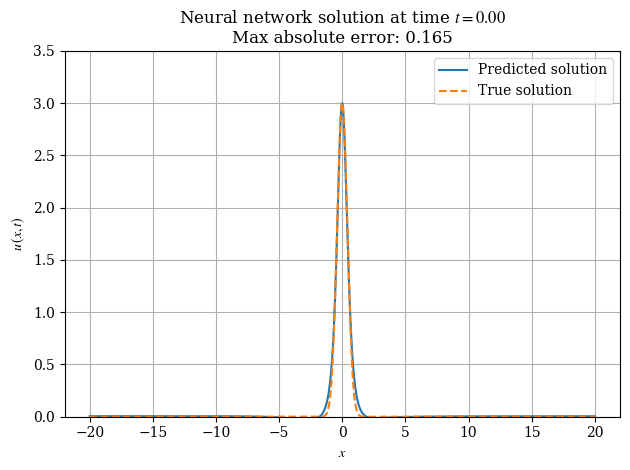

In [241]:
plot_solution(solver=pinn, time=0, ylim=(0, 3.5))

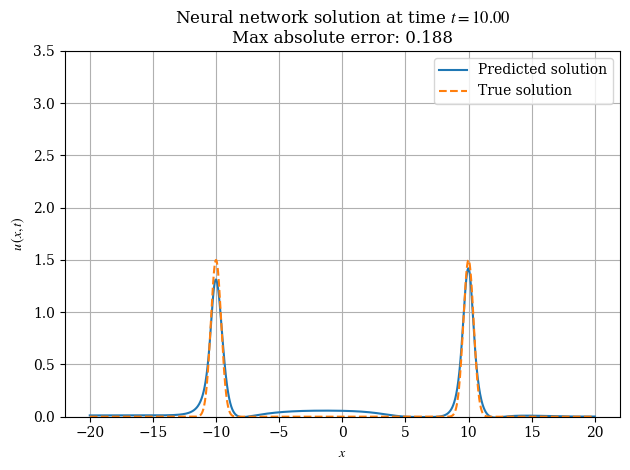

In [243]:
plot_solution(pinn, time=10)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


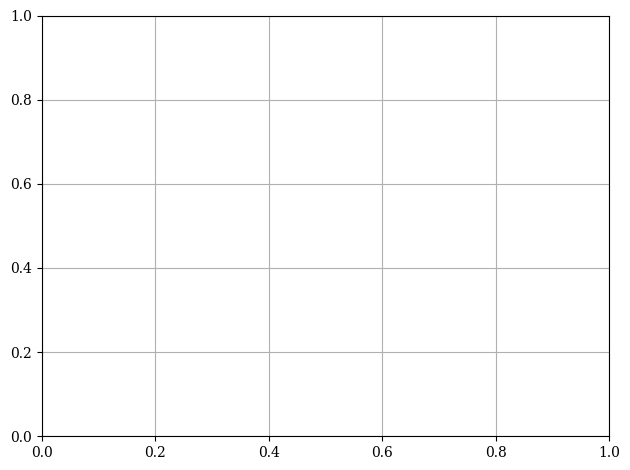

In [223]:
# save frames (which can be joined into a gif)
t_end = 10
frames = 50
for frame in trange(frames):
    t = frame * t_end/frames
    plot_solution(pinn, t, savename=f"data/wave_eq_frame_{frame}.png")

## Nonlinear wave equation

For this second part, we have another initial-boundary-value problem, but this time for the nonlinear variant of the wave equation, $u_{tt} = c^2 u_{xx} + \epsilon u^2$ (where $\epsilon \ll 1$):

$$
\begin{gather*}
u(x, 0) = A e^{-\beta x^2} \\
\dfrac{\partial u}{\partial t}(x, 0) = 0, \\
u(x) = u(x + L), \\
x \in (-\infty, \infty)
\end{gather*}
$$

There is no analytical solution; the PDE must be solved numerically. For reference, compare against the solution from [this online simulator](https://visualpde.com/sim/?options=N4IghgagliBcCMAaEAjMcQGcC2B7XALgBYBOApgA4A2YAxmSMgShgG5VQB2DytAInAIkArmWQATAKqSMAYQBUAiRBmwQSkOIgQMABkaaA6ob0HxBOLoB0u3QCZeqkPAMBrDHwAEAXk-xPnlwBANpIfrYAugDcsj6e1rrwUa5xCbaJUQYUACoYHNxZcsKYBLjYWSS4KGQAYsKcGMIVVWQAMmScAObEcABsusgkTqwGJDpqKfKewgB6dqMmavrII7DBoGAklQDusrhUuMIkfQCsJwDMJ8ibO3wdmFAEAJ6WVlfgW7jb7V3EALJgAAeGBc10+2wAyrQwFQGGowMJSgYbl8ABoYVoAfUBAHo7J4ALSeYFgnYATQxmKeeMJnhe10RuAhZAIewORwASmAunCAGYwzBiEDQ7BkEhgbJEFnoWDnAbCsCi8UABSIMFl8pFYrAAC18OVYNYABy8faHEjYMAUDAEI4oXAGWhmu2bOD8qiC02cUpHTBugVCp3e81s82WL0+kgAUQoDwODUNNiQwtwwaOADlhAb3rRiqVsBCjvz6P6PUKyNh7Zg-bB3Z6QBWq5gAIKVqAdCyJ96N3DVvhQXm84pw6y9ZA96uq9XwN4Adl0Jobld7mAhas4LwQ8onq7whCI3GrrwcS6bEIoZFzNGOiZPO8l0tes6NJwALMheRwKBfxKGjpbrVrANkHyMhDCgcwiD+YQqDgZNLUBP8xhhUQQRsAxsC4JCIBQuEQASAxcFYMUaE3OshSIkiwCeJDwxASiSFImM41TV5bHeBimMBCgb2cQjiMY6jWi4MCIP+GC4OQahCGyJ4LwwahuR4EAeKqLhOlLetVOqOoExAJopMqaofm6Ig+nlbSyFk+S1C4AgyE6cVYMMlp0SWZpqgpdzkEwIs6FqepTCYUgyDIPgAAkyCgToiAIKEYRHKxZxWS9ShIGp2yocRNKFbYiDAAhslwZUDk7EARmQThFTwlwAF9EA2cFaNgXozkuUkvjuTgHmeV53hRb4OlMgFgTUUEPh2eLYQwBEkQ67Y3JALFcXxIkSQmr4vKWqkaSJelwEZZlWWdEguR5HLeGq8UHwIGU5UupUwCnOB7oVR69TKV5FyddkLStG07QdU1frQG9yIjc0a3BlM0xIZrNVTSNmKgeM2OTINI0zbNeDzMpCxIYs+WA08Vwuknq1bFB229Prx2XPsByHQVXjHcnMGehA5wXOmz3XTd4G3end3wYhDxraw7yF89Lxg11bx5lcbplaxnzfD8vx-JCALJ0DwMg6DYIQZAEOw3C0OWEBMM4U2qFQpZ0OQTjqLJp2aJOujXeR1HE3Yx2BK4niQX4qinmE7g9fEw3k2kwq5Lw0CPPUsnLN0xoPLaIaehaiyjKsuOMDshynPTxaLcsraLd8gn-NT7yQGIcgwsi6LYqmxLkvK1LcHSzLsqAstkDygqipKwg2AMKrRTgOxaoiHyoGwbJHmmtRDDAYjPDIABHYQCqgVjaqAA).

In [583]:
constants["A"] = 1
constants["epsilon"] = 0.5
constants["c"] = 2
t_end_alt = 5 # only up to 5 seconds to prevent numerical instabilities

In [632]:
constants

{'c': 2, 'A': 1, 'beta': 3.0, 't_end': 10.0, 'epsilon': 0.5, 'period': 1.5}

In [584]:
def wave_equation_nonlinear(input_, output_, c=constants["c"], eps=constants["epsilon"]):
    u = output_.extract(["u"])
    u_t = grad(output_, input_, components=["u"], d=["t"])
    u_tt = grad(u_t, input_, components=["dudt"], d=["t"])
    u_x = grad(output_, input_, components=["u"], d=["x"])
    u_xx = grad(u_x, input_, components=["dudx"], d=["x"])
    return u_tt - (c**2 * u_xx + eps * u**2)

In [585]:
def central_point_cond(input_, output_, A=constants["A"]):
    u = output_.extract(["u"])
    return u - A # (should be zero at t=0, x=0)

In [599]:
class NonlinearWaves(SpatialProblem, TimeDependentProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [-infty, infty]})
    temporal_domain = CartesianDomain({"t": [0.0, t_end_alt]})
    dx = 0.5 # to ensure that at initial time, we match initial cond
    domains = {
        "D": CartesianDomain({"x": [-infty, infty], "t": [0.0, t_end_alt]}), # general domain
        "D0": CartesianDomain({"x": [-infty, infty], "t": 0.0}), # initial cond. 1
        "Dx0": CartesianDomain({"x": [-infty, infty], "t": 0.0}), # initial cond. 2
        "central": CartesianDomain({"x": [-dx, dx], "t": 0.0})
    }

    conditions = {
        "D": Condition(domain="D", equation=Equation(wave_equation_nonlinear)),
        "ic1": Condition(domain="D0", equation=Equation(initial_cond_1)),
        "ic2": Condition(domain="Dx0", equation=Equation(initial_cond_2)),
        "central_fixed": Condition(domain="central", equation=Equation(central_point_cond))
    }

In [619]:
nonlin_wave_problem = NonlinearWaves()

In [620]:
nonlin_model = FeedForward(len(nonlin_wave_problem.input_variables), 
                           len(nonlin_wave_problem.output_variables),
                           inner_size=30,
                           n_layers=4)

In [621]:
nonlin_model

FeedForward(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): Tanh()
    (8): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [622]:
nonlin_wave_problem.discretise_domain(10000, "random", domains="all")

In [623]:
pinn_nonlin = PINN(nonlin_wave_problem, nonlin_model, TorchOptimizer(torch.optim.Adam, lr=0.005))

In [624]:
trainer = Trainer(
    pinn_nonlin,
    max_epochs=1000,
    accelerator="cpu",
    enable_model_summary=True,
    train_size=1.0,
)
trainer.train()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Jacky\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 2.9 K  | train
1 | _loss        | MSELoss    | 0      | train
----------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1000` reached.


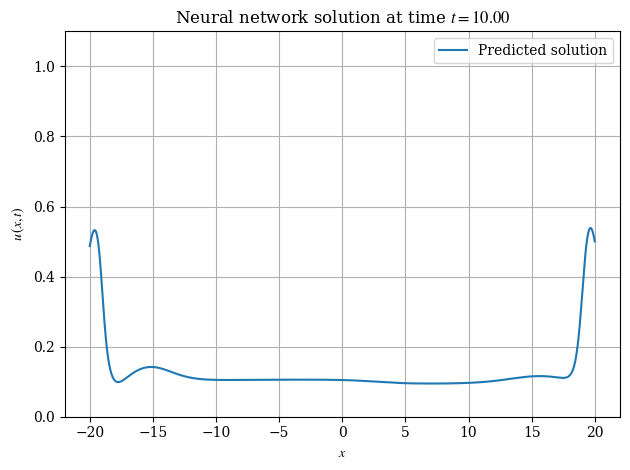

In [629]:
plot_solution(pinn_nonlin, time=10, analytical_exists=False, ylim=(0, 1.1))

In [249]:
# save results
# so no need to re-train later
wave_eq_problem_two = {
    "name": "Wave equation problem 2 (nonlinear)",
    "pinn_solver": pinn_nonlin,
}

In [87]:
# with open("reference-problem-2.pkl", "wb") as f:
#     pickle.dump(wave_eq_problem_two, f)

In [243]:
# example loading datafile
# only run if you're loading from datafile
# and you already have a datafile saved from
# previous step
with open("reference-problem-2.pkl", "rb") as f:
    wave_eq_problem_two = pickle.load(f)["problem"]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.08it/s]


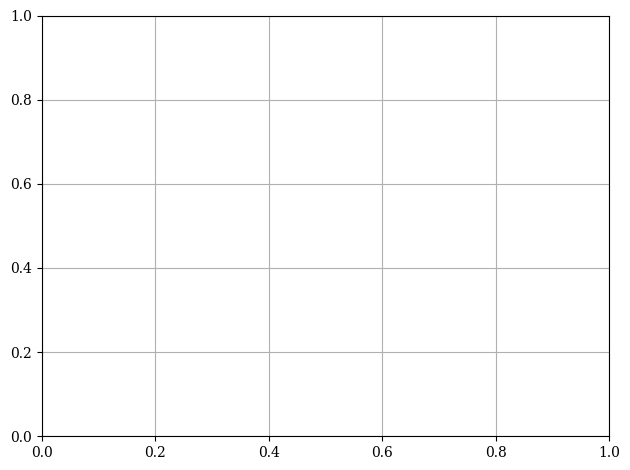

In [631]:
# save frames (which can be joined into a gif)
frames = 50
for frame in trange(frames):
    t = frame * t_end/frames
    plot_solution(pinn_nonlin, t, savename=f"data/nonlinear_wave_eq_frame_{frame}.png", analytical_exists=False)